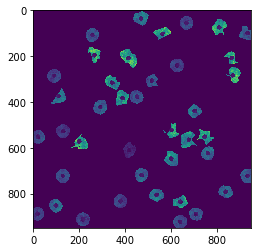

In [101]:
import glob
import skimage.io as io
import numpy as np


dir = "/projects/biocomp/Projects/Workshops/"
images_list = glob.glob(dir + "dataset/Images/*png")
#print(images_list)

images = []
images_gray = []
for image_path in images_list:
    # Reading the image
    images.append(io.imread(image_path))
    # Reading the image (gray version)
    gray_image = io.imread(image_path, as_gray=True)
    images_gray.append(gray_image)
    # Saving the image (gray version)
    #io.imsave("Gray_images/" + image_path.split("/")[-1].replace(".png", ".gray.png"), gray_image)

(array([20., 45., 78., 41., 29.,  2.,  0.,  0.,  0.,  1.]),
 array([ 4.38572521,  5.91602283,  7.44632044,  8.97661806, 10.50691568,
        12.0372133 , 13.56751091, 15.09780853, 16.62810615, 18.15840377,
        19.68870139]),
 <a list of 10 Patch objects>)

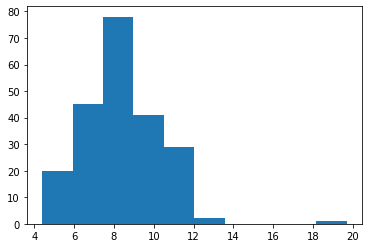

In [6]:
from matplotlib import pyplot as plt

channels_mean = [[], [], []]
i = 0
for image in images:
    for c in range(3):
        m = np.mean(image[:, :, c])
        channels_mean[c].append(m)
    i += 1

plt.hist(channels_mean[1])

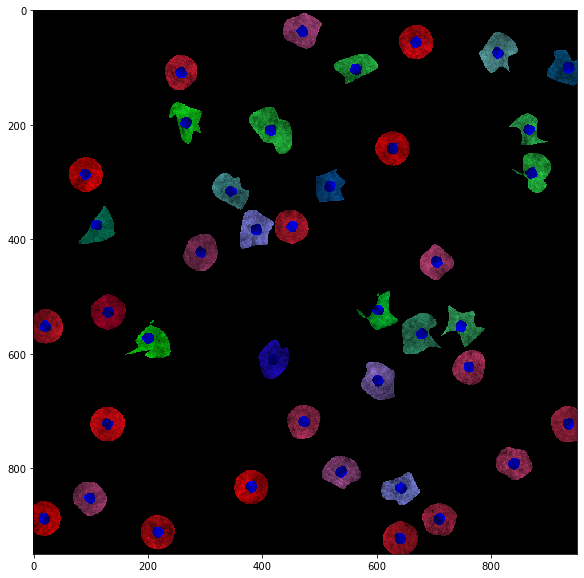

In [66]:
plt.figure(figsize=(10, 10))
plt.imshow(images[0])

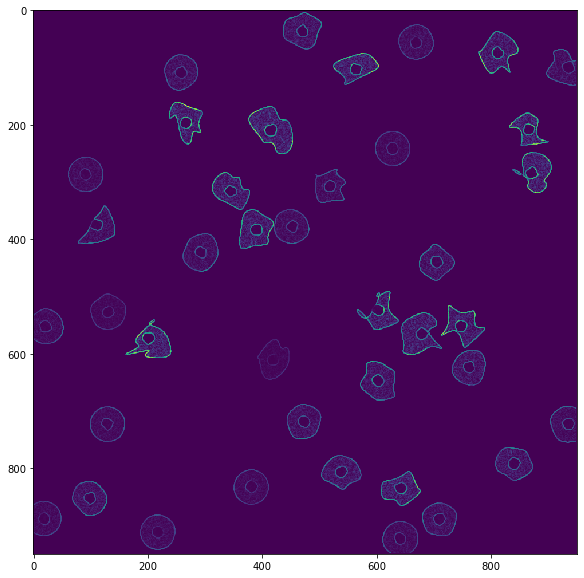

In [136]:
from skimage import filters
sob = skimage.filters.sobel(images_gray[0])
plt.figure(figsize=(10, 10))
plt.imshow(sob)

/users/biocomp/bahin/miniconda3/envs/Env_conda_Workshop_image/lib/python3.7/site-packages/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)


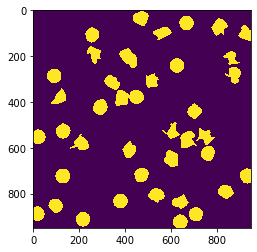

In [7]:
from skimage.morphology import watershed, disk
from skimage.filters import rank
from scipy import ndimage as ndi

markers = rank.gradient(images_gray[0], disk(2))
#markers = ndi.label(markers)[0]
#plt.imshow(markers)
#gradient = rank.gradient(images_gray[0], disk(2))
#plt.imshow(gradient)
#labels = watershed(gradient, markers)
#print(labels)
#plt.imshow(markers)
markers_no_hole = ndi.binary_fill_holes(markers)
plt.imshow(markers_no_hole)

In [9]:
import skimage

labeled, _ = ndi.label(markers_no_hole)
regions = skimage.measure.regionprops(labeled)
i = 0
res = np.zeros((len(regions), 2))
for r in regions:
    res[i][1], res[i][0] = r["Centroid"]
    i += 1
print(res)

[[469.69518717  35.20796197]
 [668.67006369  55.52452229]
 [811.78575565  73.24811812]
 [925.21246674 101.51197263]
 [563.34896017  98.96862883]
 [257.91528724 108.16553067]
 [267.39790765 192.40223665]
 [417.95424837 207.52521008]
 [864.30880361 208.53182844]
 [627.60927152 241.2901293 ]
 [877.05604431 280.88921473]
 [ 91.6494813  286.65325369]
 [517.19247187 308.8137369 ]
 [344.671      315.06833333]
 [116.2043512  381.30963481]
 [417.74325999 380.61574218]
 [292.84354744 422.94549204]
 [703.33968927 440.75812147]
 [606.88808374 528.56360709]
 [130.97497654 527.13387551]
 [750.64201283 550.70077676]
 [ 24.8642487  552.44766839]
 [672.99556483 565.10853118]
 [208.28319436 581.08050032]
 [419.76544043 610.45798178]
 [761.84002591 623.94430052]
 [603.72482639 647.93547454]
 [472.37572628 718.46191091]
 [928.34998122 722.73939166]
 [129.76048462 722.81236409]
 [839.38411458 791.06966146]
 [538.0198973  805.78145058]
 [380.63315474 832.64702175]
 [641.4762565  836.42495667]
 [ 98.73446894

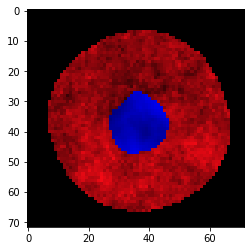

In [20]:
res_filtered = res[(res[:, 0] > 50) & (res[:, 0] < 900) & (res[:, 1] > 50) & (res[:, 1] < 900)]

for center in res_filtered:
    y1 = center[0]
    x1 = center[1]
    mini = images[0][int(np.floor(x1) - 36):int(np.floor(x1) + 36), int(np.floor(y1) - 36):int(np.floor(y1) + 36),:]
    io.imsave(dir + "Mini_images/" + image_path.split("/")[-1].replace(".png", ".gray.png"), gray_image)
    plt.imshow(mini)
    sys.exit()

In [2]:
import matplotlib.pyplot as plt

images_larger_border = []
for image in images:
    new = np.zeros((1022, 1022, 3), dtype=int)
    new[36:986, 36:986, 0:3] = image
    images_larger_border.append(new)

In [150]:
from skimage.filters import rank
from skimage.morphology import watershed, disk
from scipy import ndimage as ndi
import skimage
import pandas as pd
import os

# Loading ground truth labels
filepath = "/projects/biocomp/Projects/Workshops/dataset/ground_truth.CELLMASK.csv"
labels = pd.read_csv(filepath, header=0, sep=";")

i = 0
k = 0
for image, image_gray, image_path in zip(images_larger_border, images_gray, images_list):
    j += 1
    if k % 10 == 0:
        print("Processing image number " + str(k) + "...")
    # Segmentation
    markers = rank.gradient(image_gray, disk(2))
    # Removing the nuclei (holes here)
    markers_no_hole = ndi.binary_fill_holes(markers)
    labeled, _ = ndi.label(markers_no_hole)
    # Labelling the regions
    region_labels = skimage.measure.regionprops(labeled)
    # Formatting the region coordinates
    j = 0
    regions = np.zeros((len(region_labels), 2), dtype=int)
    for r in region_labels:
        regions[j][1], regions[j][0] = r["Centroid"]
        j += 1
    regions += [36, 36]
    # Filtering border cells
    regions_filtered = regions
    # Storing a mini image per region
    image_name = image_path.split("/")[-1][0:-4]
    os.mkdir(dir + "Mathieu/Mini_images/" + image_name)
    for region in regions_filtered:
        x1 = region[0]
        y1 = region[1]
        # Finding the corresponding label
        #approximating = np.abs(labels.loc[labels.ImageName == image_name, "LocationX"] + 36 - x1) + np.abs(labels.loc[labels.ImageName == image_name, "LocationY"] + 36 - y1)
        approximating = np.abs(labels.loc[labels.ImageName == image_name, "LocationY"] + 36 - x1) + np.abs(labels.loc[labels.ImageName == image_name, "LocationX"] + 36 - y1)
        idx = approximating.idxmin(axis=0)
        image_filename = image_name + "_" + str(i) + ".png"
        labels.loc[idx, "PNG"] = image_filename
        # Defining the mini image
        mini = image[int(np.floor(y1) - 36):int(np.floor(y1) + 36), int(np.floor(x1) - 36):int(np.floor(x1) + 36), :]
        #plt.imshow(mini)
        io.imsave(dir + "Mathieu/Mini_images/" + image_name + "/" + image_filename, mini, check_contrast=False)
        i += 1
    labels.to_csv(dir + "Mathieu/Mini_images/labels.tsv", sep="\t")
    sys.exit()
# Storing the associated labels
labels.to_csv(dir + "Mathieu/Mini_images/labels.tsv", sep="\t")

Processing image number 0...


Lossy conversion from int64 to uint8. Range [0, 208]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 244]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 232]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 232]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 237]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 255]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int64 to uint8. Range [0, 

NameError: name 'sys' is not defined

,LocationX,LocationY,ProcessID,PNG
5689,22,552,3,ProcessPlateSparse_wC04_s08_z1_t1_CELLMASK_0.png
5699,130,723,3,ProcessPlateSparse_wC04_s08_z1_t1_CELLMASK_1.png
5702,218,912,3,ProcessPlateSparse_wC04_s08_z1_t1_CELLMASK_10.png
5695,258,109,3,ProcessPlateSparse_wC04_s08_z1_t1_CELLMASK_11.png
5696,292,423,3,ProcessPlateSparse_wC04_s08_z1_t1_CELLMASK_12.png
5704,345,316,4,ProcessPlateSparse_wC04_s08_z1_t1_CELLMASK_13.png
5683,390,383,3,ProcessPlateSparse_wC04_s08_z1_t1_CELLMASK_15.png
5707,415,210,3,ProcessPlateSparse_wC04_s08_z1_t1_CELLMASK_16.png
5700,473,719,3,ProcessPlateSparse_wC04_s08_z1_t1_CELLMASK_17.png
5680,419,610,6,ProcessPlateSparse_wC04_s08_z1_t1_CELLMASK_18.png


5680    ProcessPlateSparse_wC04_s08_z1_t1_CELLMASK_18.png
Name: PNG, dtype: object


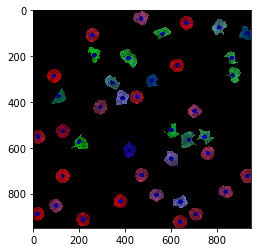

In [151]:
plt.imshow(images[0])
display(labels.loc[labels.ImageName == image_name, ["LocationX", "LocationY", "ProcessID", "PNG"]].sort_values("PNG"))
print(labels.loc[(labels.ImageName == image_name) & (labels.CellIdx == 1), "PNG"])

In [4]:
import pandas as pd

labels = pd.read_csv(dir + "Mathieu/Mini_images/labels.tsv", sep="\t", index_col=0)
display(labels.head())

,ImageName,CellIdx,LocationX,LocationY,ColorParamsR,ColorParamsG,ColorParamsB,ShapeParams,ProcessID,PositionOnRegressionPlaneX,PositionOnRegressionPlaneY,loc_diff,PNG
0,ProcessPlateSparse_wA01_s01_z1_t1_CELLMASK,1,784,420,0.607316,0.321287,0.713971,0.178493,4,0.678713,0.607316,995.0,NaN
1,ProcessPlateSparse_wA01_s01_z1_t1_CELLMASK,2,522,812,0.265482,0.675522,0.589959,0.352510,4,0.324478,0.265482,341.0,ProcessPlateSparse_wA01_s01_z1_t1_CELLMASK_216...
2,ProcessPlateSparse_wA01_s01_z1_t1_CELLMASK,3,208,511,0.885511,0.093673,0.208162,0.052040,4,0.906327,0.885511,442.0,ProcessPlateSparse_wA01_s01_z1_t1_CELLMASK_215...
3,ProcessPlateSparse_wA01_s01_z1_t1_CELLMASK,4,11,566,0.481796,0.091448,0.609652,0.152413,5,0.908552,0.481796,584.0,ProcessPlateSparse_wA01_s01_z1_t1_CELLMASK_215...
4,ProcessPlateSparse_wA01_s01_z1_t1_CELLMASK,5,243,742,0.485673,0.420813,0.935140,0.233785,4,0.579187,0.485673,176.0,ProcessPlateSparse_wA01_s01_z1_t1_CELLMASK_216...


In [77]:
import skimage.io as io
import re

# Loading images and labels
mini_images = []
labels.loc[:, "ProcessID_0-based"] = labels["ProcessID"] - 1
process_IDs = labels.dropna().loc[:, "ProcessID_0-based"].tolist()
mini_image_paths = labels.dropna().loc[:, "PNG"].tolist()
for process_ID, mini_image_path in zip(process_IDs, mini_image_paths):
    mini_image_dir = re.sub("_[0-9]*.png", "", mini_image_path)
    mini_images.append(io.imread(dir + "Mathieu/Mini_images/" + mini_image_dir + "/" + mini_image_path))
print(process_IDs[0])

3


In [78]:
import keras.utils
from sklearn.model_selection import train_test_split

process_IDs_to_cat = keras.utils.to_categorical(process_IDs, num_classes=7)
mini_images_train, mini_images_test, process_IDs_train, process_IDs_test = train_test_split(mini_images, process_IDs_to_cat)

In [80]:
mini_images_train2 = np.array(mini_images_train) / 127.5 - 1
mini_images_test2 = np.array(mini_images_test) / 127.5 - 1

In [79]:
from keras import Sequential
from keras.layers import Dense, Flatten

model = Sequential()
model.add(Flatten(input_shape=(72, 72, 3)))
model.add(Dense(2048, activation="relu"))
model.add(Dense(7, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 15552)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 2048)              31852544  
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 14343     
Total params: 31,866,887
Trainable params: 31,866,887
Non-trainable params: 0
_________________________________________________________________


In [154]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
def alexnet(in_shape=(128, 128, 3), n_classes=2):
    model = Sequential()
    model.add( Conv2D(96, 11, strides=4, activation='relu', input_shape=in_shape, padding='same') )
    model.add( MaxPool2D(pool_size=(3, 2), dim_ordering='tf') )
    model.add( Conv2D(256, 5, strides=1, padding='same', activation='relu') )
    model.add( MaxPool2D(pool_size=(3, 2), dim_ordering='tf') )
    model.add( Conv2D(384, 3, strides=1, padding='same', activation='relu') )
    model.add( Flatten() )
    model.add( Dense(4096, activation='relu') )
    model.add( Dropout(rate=0.5) )
    model.add( Dense(4096, activation='relu') )
    model.add( Dropout(rate=0.5) )
    model.add( Dense(n_classes, activation='softmax') )
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [156]:
model = alexnet(in_shape=(72, 72, 3), n_classes=7)
model.fit(mini_images_train2, process_IDs_train, epochs=10, batch_size=32, validation_data=(mini_images_test2, process_IDs_test))

/users/biocomp/bahin/miniconda3/envs/Env_conda_Workshop_image/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 2), data_format="channels_last")`
  """
/users/biocomp/bahin/miniconda3/envs/Env_conda_Workshop_image/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(3, 2), data_format="channels_last")`
  import sys


Train on 6191 samples, validate on 2064 samples
Epoch 1/10
6191/6191 [==============================] - 40s 6ms/step - loss: 11.1008 - acc: 0.3077 - val_loss: 11.6044 - val_acc: 0.2800
Epoch 2/10
6191/6191 [==============================] - 39s 6ms/step - loss: 11.1350 - acc: 0.3092 - val_loss: 11.6044 - val_acc: 0.2800
Epoch 3/10
6191/6191 [==============================] - 39s 6ms/step - loss: 11.1350 - acc: 0.3092 - val_loss: 11.6044 - val_acc: 0.2800
Epoch 4/10
6191/6191 [==============================] - 30s 5ms/step - loss: 11.1350 - acc: 0.3092 - val_loss: 11.6044 - val_acc: 0.2800
Epoch 5/10
6191/6191 [==============================] - 30s 5ms/step - loss: 11.1324 - acc: 0.3093 - val_loss: 11.6044 - val_acc: 0.2800
Epoch 6/10
6191/6191 [==============================] - 30s 5ms/step - loss: 11.1350 - acc: 0.3092 - val_loss: 11.6044 - val_acc: 0.2800
Epoch 7/10
6191/6191 [==============================] - 33s 5ms/step - loss: 11.1350 - acc: 0.3092 - val_loss: 11.6044 - val_acc: 

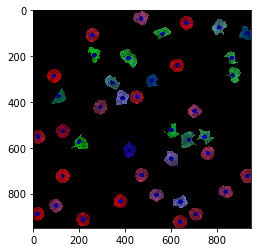

In [82]:
plt.imshow(images[0])

3


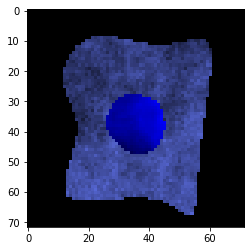

In [93]:
x = 4
print(process_IDs[x])
plt.imshow(mini_images_train[x])